# 다섯가지 꽃 종류 분류 🌼🌱🌹🌻🌷
- 데이지, 민들레, 장미, 해바라기, 튤립
- 출처 : https://www.kaggle.com/datasets/alxmamaev/flowers-recognition

In [98]:
from tensorflow.keras.utils import set_random_seed, plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, VGG19
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import PIL.Image as pilimg
import numpy as np
import os
import cv2

## [1] 데이터 불러오기

In [3]:
flowers=['daisy', 'dandelion', 'rose','sunflower', 'tulip']

In [70]:
def get_image(flower):
    # 이미지 담을 리스트, 파일 경로 생성
    hr_image = []
    target=[]
    
    for flower in flowers:
        a=1
        PATH = r'./file/'+flower+'/'

        # 폴더 내 모든 이미지 읽고 저장
        for filename in os.listdir(PATH): 
            if a<=500:
                img = cv2.imread(PATH + filename)
                # 색깔이 바뀌어서 나오는 것 바로잡기
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                resize_img=cv2.resize(img, (224, 224))
                hr_image.append(resize_img)

                target.append(flower)
                a+=1
                

    # numpy 배열 형태로 저장
    hr_image = np.array(hr_image)
    target=np.array(target)
    
    return hr_image, target

In [71]:
data, target=get_image(flowers)

In [311]:
data.shape

(2500, 224, 224, 3)

In [312]:
target.shape

(2500,)

In [78]:
# 스케일링
data=data/255.0

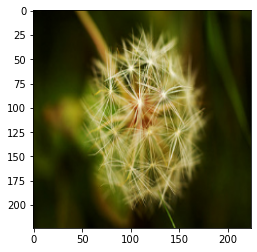

In [80]:
plt.imshow(data[500])

## [2] 데이터 분리

In [81]:
x_train, x_test, y_train, y_test=train_test_split(
data, target, stratify=target, test_size=0.2, random_state=42)

In [82]:
print(f'x_train.shape : {x_train.shape}, x_test.shape : {x_test.shape}')
print(f'y_train.shape : {y_train.shape}, y_test.shape : {y_test.shape}')

x_train.shape : (2000, 224, 224, 3), x_test.shape : (500, 224, 224, 3)
y_train.shape : (2000,), y_test.shape : (500,)


In [83]:
x_train, x_val, y_train, y_val=train_test_split(
x_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

In [84]:
print(f'x_train.shape : {x_train.shape}, x_val.shape : {x_val.shape}')
print(f'y_train.shape : {y_train.shape}, y_val.shape : {y_val.shape}')

x_train.shape : (1600, 224, 224, 3), x_val.shape : (400, 224, 224, 3)
y_train.shape : (1600,), y_val.shape : (400,)


### target OneHotEncoding

In [85]:
y_train=y_train.reshape(-1, 1)
y_test=y_test.reshape(-1, 1)
y_val=y_val.reshape(-1, 1)

In [86]:
ohe=OneHotEncoder()

In [87]:
ohe.fit(y_train)

OneHotEncoder()

In [88]:
y_train=ohe.transform(y_train)
y_test=ohe.transform(y_test)
y_val=ohe.transform(y_val)

In [89]:
y_train=y_train.toarray()
y_test=y_test.toarray()
y_val=y_val.toarray()

In [90]:
y_train

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

## [3] 모델 생성 및 학습

## CNN

In [91]:
# W, b 초기값 고정
set_random_seed(11)

In [93]:
def cnnModel(num):
    model=Sequential()
    model.add(Conv2D(filters=num, kernel_size=3,
                    padding='same',
                    input_shape=(224, 224, 3)))
    model.add(MaxPool2D())
    model.add(Conv2D(filters=num*2, kernel_size=3,
                    padding='same'))
    model.add(Conv2D(filters=num*2, kernel_size=3,
                    padding='same'))
    model.add(MaxPool2D())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                 metrics=['accuracy'])
    
    return model

In [202]:
cnn_model=cnnModel(64)

In [95]:
stopCB=EarlyStopping(monitor='val_accuracy', patience=5)

In [96]:
MODEL_PATH='./model/model.{epoch:02d}-{val_loss:.2f}.h5'
modelCB=ModelCheckpoint(filepath=MODEL_PATH,
                       save_best_only=True)

In [203]:
his=cnn_model.fit(x_train, y_train, epochs=10, batch_size=100,
             validation_data=(x_val, y_val),
             callbacks=[stopCB, modelCB])

Epoch 1/10
16/16 [==============================] - 291s 18s/step - loss: 8.0711 - accuracy: 0.2381 - val_loss: 1.6439 - val_accuracy: 0.2850
Epoch 2/10
16/16 [==============================] - 259s 16s/step - loss: 1.6289 - accuracy: 0.2587 - val_loss: 1.5239 - val_accuracy: 0.2725
Epoch 3/10
16/16 [==============================] - 260s 16s/step - loss: 1.5701 - accuracy: 0.2237 - val_loss: 1.5203 - val_accuracy: 0.2850
Epoch 4/10
16/16 [==============================] - 259s 16s/step - loss: 1.5749 - accuracy: 0.2250 - val_loss: 1.5543 - val_accuracy: 0.2475
Epoch 5/10
16/16 [==============================] - 261s 16s/step - loss: 1.5600 - accuracy: 0.2375 - val_loss: 1.5279 - val_accuracy: 0.2725
Epoch 6/10
16/16 [==============================] - 262s 17s/step - loss: 1.5554 - accuracy: 0.2594 - val_loss: 1.5086 - val_accuracy: 0.3300
Epoch 7/10
16/16 [==============================] - 261s 16s/step - loss: 1.5290 - accuracy: 0.2619 - val_loss: 1.5202 - val_accuracy: 0.2700
Epoch 

---
## VGG16

In [109]:
model=VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

for layer in vgg_model.layers[:19]:
        layer.trainable = False

In [110]:
model = Sequential([
        model,
        Conv2D(64, kernel_size=3, padding='same'),
        MaxPool2D(),
        Dropout(0.5),
        Flatten(),
        Dense(5 , activation='softmax')])
model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_28 (Conv2D)          (None, 7, 7, 64)          294976    
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 3, 3, 64)         0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 3, 3, 64)          0         
                                                                 
 flatten_12 (Flatten)        (None, 576)               0         
                                                                 
 dense_19 (Dense)            (None, 5)                 2885      
                                                     

In [111]:
history = model.fit(x_train,y_train, batch_size = 100 , epochs = 12 , validation_data = (x_val, y_val), callbacks = [stopCB, modelCB])

Epoch 1/12
16/16 [==============================] - 399s 25s/step - loss: 1.4943 - accuracy: 0.4538 - val_loss: 0.8519 - val_accuracy: 0.7175
Epoch 2/12
16/16 [==============================] - 405s 26s/step - loss: 0.7115 - accuracy: 0.7431 - val_loss: 0.6840 - val_accuracy: 0.7850
Epoch 3/12
16/16 [==============================] - 399s 25s/step - loss: 0.4990 - accuracy: 0.8350 - val_loss: 0.6386 - val_accuracy: 0.7900
Epoch 4/12
16/16 [==============================] - 385s 24s/step - loss: 0.3715 - accuracy: 0.8756 - val_loss: 0.6391 - val_accuracy: 0.7850
Epoch 5/12
16/16 [==============================] - 381s 24s/step - loss: 0.3321 - accuracy: 0.8888 - val_loss: 0.6547 - val_accuracy: 0.7650
Epoch 6/12
16/16 [==============================] - 378s 24s/step - loss: 0.2576 - accuracy: 0.9194 - val_loss: 0.5872 - val_accuracy: 0.8075
Epoch 7/12
16/16 [==============================] - 377s 24s/step - loss: 0.2064 - accuracy: 0.9438 - val_loss: 0.5709 - val_accuracy: 0.8025
Epoch 

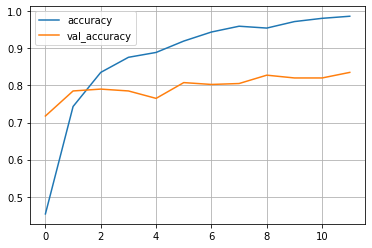

In [114]:
plt.plot(history.epoch, history.history['accuracy'])
plt.plot(history.epoch, history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.grid()
plt.show()

In [115]:
model.evaluate(x_test, y_test)

16/16 [==============================] - 83s 5s/step - loss: 0.5145 - accuracy: 0.8380


[0.5144973993301392, 0.8379999995231628]

In [120]:
np.round(model.predict(x_test[0].reshape(-1, 224, 224, 3)))

1/1 [==============================] - 0s 231ms/step


array([[0., 0., 0., 0., 1.]], dtype=float32)

In [121]:
y_test[0]

array([0., 0., 0., 0., 1.])

## [4] 예측

In [313]:
# 폴더 내 모든 이미지 읽고 저장
pre_flower=[]
PATH = './new_img/'

for filename in os.listdir(PATH):
    image=cv2.imread(PATH+filename)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image=cv2.resize(image, (224, 224))
    pre_flower.append(image)
    
pre_flower=np.array(pre_flower)
pre_flower=pre_flower/255.0

In [314]:
def pre_label(pre_target):
    '''
    예측값의 라벨 출력
    '''
    
    if pre_target[0][0]==1: return 'daisy'
    elif pre_target[0][1]==1: return 'dandelion'
    elif pre_target[0][2]==1: return 'rose'
    elif pre_target[0][3]==1: return 'sunflower'
    else: return 'tulip'

In [315]:
def pre_img(i, pre_target, answers):
    plt.imshow(pre_flower[i])
    plt.show()
    
    print(f'예측 => {pre_target} {pre_label(pre_target)}')
    print(f'정답 => {answers[i]}')

In [316]:
def model_predict(model):
    for i in range(len(pre_flower)):
        answers=['daisy','daisy', 'daisy', 'daisy', 'daisy',
                 'dandelion', 'dandelion', 'dandelion', 
                 'rose', 'rose', 
                 'sunflower', 'sunflower', 
                 'tulip', 'tulip', 'tulip', 'tulip', 'egg']
        pre_target=np.round(model.predict(pre_flower[i].reshape(-1, 224, 224, 3)))

        if i in [0, 1, 2, 3, 4]:
            pre_img(i, pre_target, answers)
            if int(pre_target[0][0])==1: print('✿ڿڰۣ 데이지 정답🌼 ✿ڿڰۣ')
            else: print('땡 ( ꃼ-ꃼ )')

        elif i in [5, 6, 7]:
            pre_img(i, pre_target, answers)

            if int(pre_target[0][1])==1: print('✿ڿڰۣ 민들레 정답🌱 ✿ڿڰۣ')
            else: print('땡 ( ꃼ-ꃼ )')

        elif i in [8, 9]:
            pre_img(i, pre_target, answers)

            if int(pre_target[0][2])==1: print('✿ڿڰۣ 장미 정답🌹 ✿ڿڰۣ')
            else: print('땡 ( ꃼ-ꃼ )')

        elif i in [10, 11]:
            pre_img(i, pre_target, answers)

            if int(pre_target[0][3])==1: print('✿ڿڰۣ 해바라기 정답🌻 ✿ڿڰۣ')
            else: print('땡 ( ꃼ-ꃼ )')

        else:
            pre_img(i, pre_target, answers)

            if int(pre_target[0][4])==1: print('✿ڿڰۣ 튤립 정답🌷 ✿ڿڰۣ')
            else: print('땡 ( ꃼ-ꃼ )')

### CNN 모델 예측

1/1 [==============================] - 0s 125ms/step


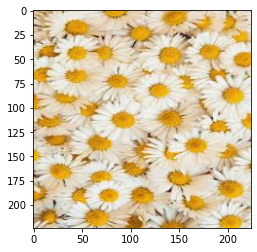

예측 => [[0. 0. 0. 0. 0.]] tulip
정답 => daisy
땡 ( ꃼ-ꃼ )
1/1 [==============================] - 0s 69ms/step


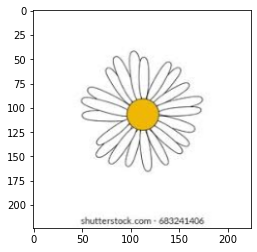

예측 => [[0. 0. 0. 0. 0.]] tulip
정답 => daisy
땡 ( ꃼ-ꃼ )
1/1 [==============================] - 0s 85ms/step


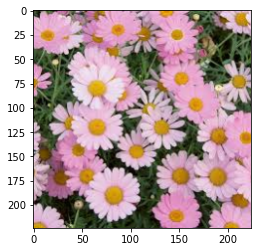

예측 => [[0. 0. 0. 0. 0.]] tulip
정답 => daisy
땡 ( ꃼ-ꃼ )
1/1 [==============================] - 0s 84ms/step


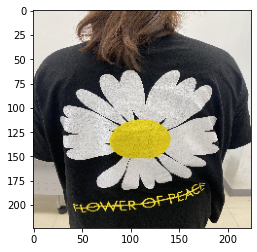

예측 => [[0. 0. 0. 0. 0.]] tulip
정답 => daisy
땡 ( ꃼ-ꃼ )
1/1 [==============================] - 0s 81ms/step


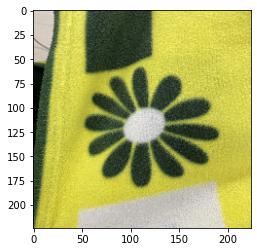

예측 => [[0. 0. 0. 0. 0.]] tulip
정답 => daisy
땡 ( ꃼ-ꃼ )
1/1 [==============================] - 0s 77ms/step


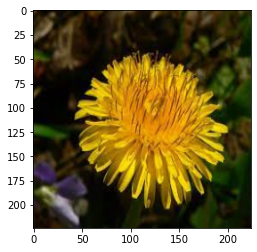

예측 => [[0. 0. 0. 0. 0.]] tulip
정답 => dandelion
땡 ( ꃼ-ꃼ )
1/1 [==============================] - 0s 83ms/step


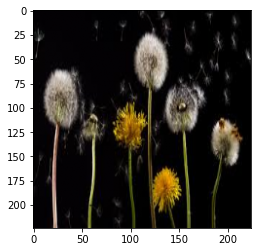

예측 => [[0. 0. 0. 0. 0.]] tulip
정답 => dandelion
땡 ( ꃼ-ꃼ )
1/1 [==============================] - 0s 78ms/step


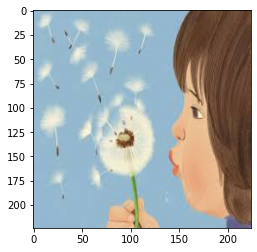

예측 => [[0. 0. 0. 0. 0.]] tulip
정답 => dandelion
땡 ( ꃼ-ꃼ )
1/1 [==============================] - 0s 79ms/step


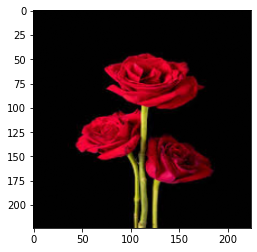

예측 => [[0. 0. 1. 0. 0.]] rose
정답 => rose
✿ڿڰۣ 장미 정답🌹 ✿ڿڰۣ
1/1 [==============================] - 0s 76ms/step


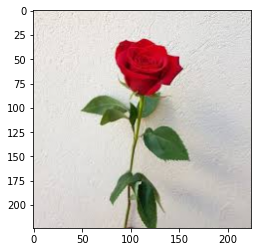

예측 => [[0. 0. 0. 0. 0.]] tulip
정답 => rose
땡 ( ꃼ-ꃼ )
1/1 [==============================] - 0s 79ms/step


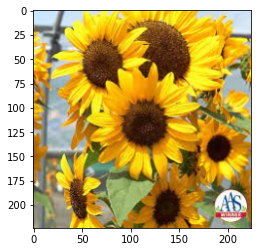

예측 => [[0. 0. 0. 0. 0.]] tulip
정답 => sunflower
땡 ( ꃼ-ꃼ )
1/1 [==============================] - 0s 93ms/step


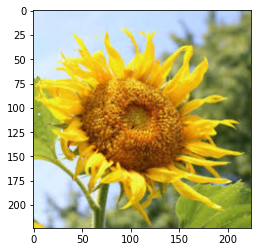

예측 => [[0. 0. 0. 0. 0.]] tulip
정답 => sunflower
땡 ( ꃼ-ꃼ )
1/1 [==============================] - 0s 67ms/step


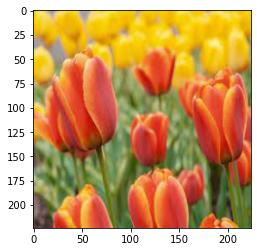

예측 => [[0. 0. 0. 0. 0.]] tulip
정답 => tulip
땡 ( ꃼ-ꃼ )
1/1 [==============================] - 0s 78ms/step


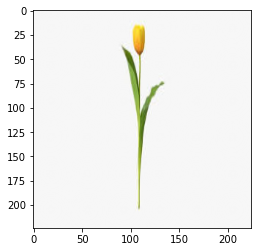

예측 => [[0. 0. 0. 0. 0.]] tulip
정답 => tulip
땡 ( ꃼ-ꃼ )
1/1 [==============================] - 0s 82ms/step


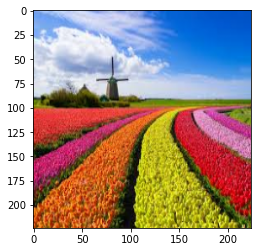

예측 => [[0. 0. 0. 0. 0.]] tulip
정답 => tulip
땡 ( ꃼ-ꃼ )
1/1 [==============================] - 0s 84ms/step


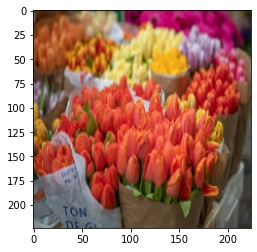

예측 => [[0. 0. 1. 0. 0.]] rose
정답 => tulip
땡 ( ꃼ-ꃼ )


In [294]:
model_predict(cnn_model)

### VGG16 모델 예측

1/1 [==============================] - 0s 229ms/step


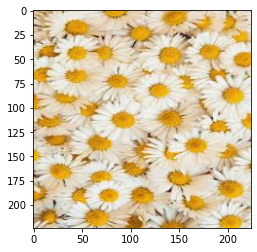

예측 => [[1. 0. 0. 0. 0.]] daisy
정답 => daisy
✿ڿڰۣ 데이지 정답🌼 ✿ڿڰۣ
1/1 [==============================] - 0s 233ms/step


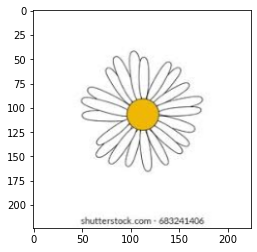

예측 => [[1. 0. 0. 0. 0.]] daisy
정답 => daisy
✿ڿڰۣ 데이지 정답🌼 ✿ڿڰۣ
1/1 [==============================] - 0s 214ms/step


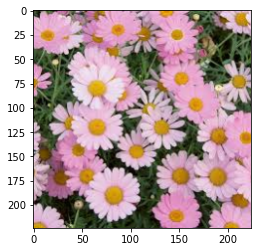

예측 => [[1. 0. 0. 0. 0.]] daisy
정답 => daisy
✿ڿڰۣ 데이지 정답🌼 ✿ڿڰۣ
1/1 [==============================] - 0s 186ms/step


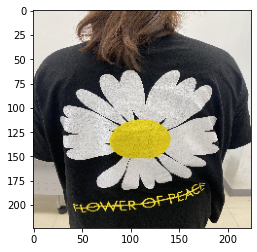

예측 => [[1. 0. 0. 0. 0.]] daisy
정답 => daisy
✿ڿڰۣ 데이지 정답🌼 ✿ڿڰۣ
1/1 [==============================] - 0s 175ms/step


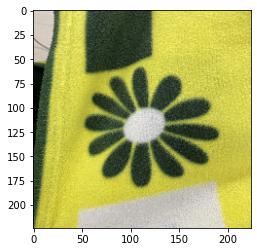

예측 => [[1. 0. 0. 0. 0.]] daisy
정답 => daisy
✿ڿڰۣ 데이지 정답🌼 ✿ڿڰۣ
1/1 [==============================] - 0s 171ms/step


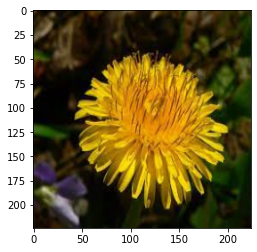

예측 => [[0. 1. 0. 0. 0.]] dandelion
정답 => dandelion
✿ڿڰۣ 민들레 정답🌱 ✿ڿڰۣ
1/1 [==============================] - 0s 168ms/step


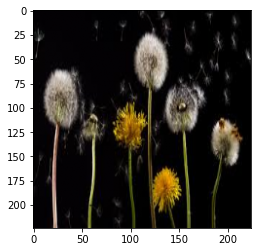

예측 => [[0. 1. 0. 0. 0.]] dandelion
정답 => dandelion
✿ڿڰۣ 민들레 정답🌱 ✿ڿڰۣ
1/1 [==============================] - 0s 178ms/step


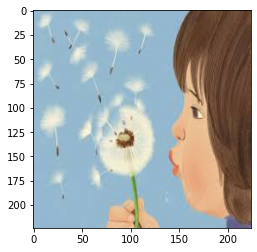

예측 => [[0. 0. 0. 0. 1.]] tulip
정답 => dandelion
땡 ( ꃼ-ꃼ )
1/1 [==============================] - 0s 170ms/step


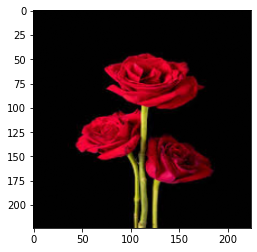

예측 => [[0. 0. 1. 0. 0.]] rose
정답 => rose
✿ڿڰۣ 장미 정답🌹 ✿ڿڰۣ
1/1 [==============================] - 0s 173ms/step


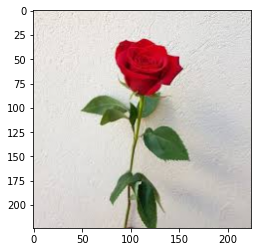

예측 => [[0. 0. 1. 0. 0.]] rose
정답 => rose
✿ڿڰۣ 장미 정답🌹 ✿ڿڰۣ
1/1 [==============================] - 0s 172ms/step


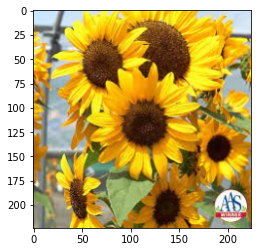

예측 => [[0. 0. 0. 1. 0.]] sunflower
정답 => sunflower
✿ڿڰۣ 해바라기 정답🌻 ✿ڿڰۣ
1/1 [==============================] - 0s 178ms/step


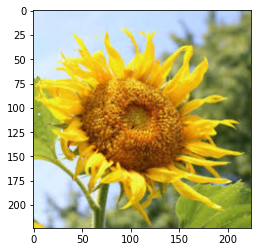

예측 => [[0. 0. 0. 1. 0.]] sunflower
정답 => sunflower
✿ڿڰۣ 해바라기 정답🌻 ✿ڿڰۣ
1/1 [==============================] - 0s 179ms/step


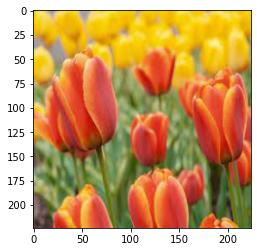

예측 => [[0. 0. 0. 0. 1.]] tulip
정답 => tulip
✿ڿڰۣ 튤립 정답🌷 ✿ڿڰۣ
1/1 [==============================] - 0s 186ms/step


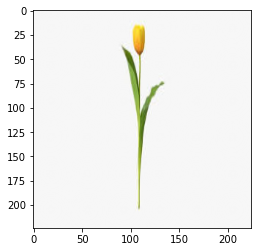

예측 => [[0. 0. 0. 0. 1.]] tulip
정답 => tulip
✿ڿڰۣ 튤립 정답🌷 ✿ڿڰۣ
1/1 [==============================] - 0s 181ms/step


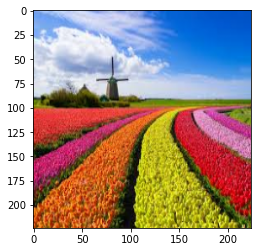

예측 => [[0. 0. 0. 0. 1.]] tulip
정답 => tulip
✿ڿڰۣ 튤립 정답🌷 ✿ڿڰۣ
1/1 [==============================] - 0s 169ms/step


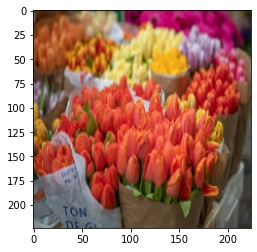

예측 => [[0. 0. 0. 0. 1.]] tulip
정답 => tulip
✿ڿڰۣ 튤립 정답🌷 ✿ڿڰۣ
1/1 [==============================] - 0s 170ms/step


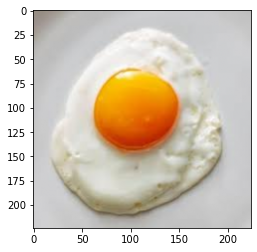

예측 => [[1. 0. 0. 0. 0.]] daisy
정답 => egg
땡 ( ꃼ-ꃼ )


In [317]:
model_predict(model)